# Step 3: Data Analysis

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
current_dir = os.getcwd()
dir_contents = os.listdir(current_dir)

for filename in dir_contents:
    file_path = os.path.join(current_dir, filename)
    if os.path.isfile(file_path):
        print(filename)

creating_dataframe.ipynb
data_analysis.ipynb
data_preprocessing.ipynb
dt_and_rf_from_scratch.ipynb
helper_functions.py
sklearn_dt_and_rf.ipynb


In [3]:
df = pd.read_csv('../dataset/preprocessed_q1_2019.csv')

In [4]:
df.shape

(9522894, 33)

In [5]:
df.head()

,date,serial_number,model,capacity_bytes,failure,smart_1_normalized,smart_1_raw,smart_3_normalized,smart_3_raw,smart_4_normalized,...,smart_193_normalized,smart_193_raw,smart_194_normalized,smart_194_raw,smart_197_normalized,smart_197_raw,smart_198_normalized,smart_198_raw,smart_199_normalized,smart_199_raw
0,2019-01-01,Z305B2QN,ST4000DM000,4000787030016,0,111.0,35673128.0,91.0,0.0,100.0,...,83.0,34169.0,20.0,20.0,100.0,0.0,100.0,0.0,200.0,0.0
1,2019-01-01,ZJV0XJQ4,ST12000NM0007,12000138625024,0,83.0,187116872.0,98.0,0.0,100.0,...,99.0,2145.0,28.0,28.0,100.0,0.0,100.0,0.0,200.0,0.0
2,2019-01-01,ZJV0XJQ3,ST12000NM0007,12000138625024,0,73.0,19599104.0,99.0,0.0,100.0,...,100.0,363.0,34.0,34.0,100.0,0.0,100.0,0.0,200.0,0.0
3,2019-01-01,ZJV0XJQ0,ST12000NM0007,12000138625024,0,81.0,136943696.0,93.0,0.0,100.0,...,100.0,687.0,22.0,22.0,100.0,0.0,100.0,0.0,200.0,0.0
4,2019-01-01,PL1331LAHG1S4H,HGST HMS5C4040ALE640,4000787030016,0,100.0,0.0,100.0,436.0,100.0,...,100.0,183.0,193.0,31.0,100.0,0.0,100.0,0.0,200.0,0.0


## Proving that within Q1 2019 data, all unique hard drives that have failed have only failed once within the dataset

### Checking the number of unique HDDs

In [6]:
df['serial_number'].nunique()

114574

### Creating a new column 'total_failures' by summing the 'failure' column for each unique HDD

In [7]:
df['total_failures'] = df.groupby('serial_number')['failure'].transform('sum')

In [8]:
df[df['total_failures'] == 1].shape

(18588, 34)

### Checking the number of unique HDDs where their total failure is greater than 1

In [9]:
df[df['total_failures'] > 1]['serial_number'].nunique()

0

### Dropping the total_failures column as it's not needed anymore

In [16]:
df = df.drop('total_failures', axis=1)

## Emulating Backblaze's method to calculate the annual failure rate from their SQL files

### Step 1: Creating a dataframe that has the number of drive days for each model. Drive days refers to the number of days a hard drive has been running (the number of rows in the main dataframe for that model).
### Written in SQL like this:

``` SQL
CREATE TABLE drive_days AS
    SELECT model, count(*) AS drive_days 
    FROM drive_stats 
    GROUP BY model;  
```

In [18]:
# Groups the dataframe by the 'model' column and calculates the size (number of rows) for each group
# The .size() gets the count of occurrences for each model
drive_days = df.groupby('model').size().reset_index(name='drive_days')

# Sort the dataframe by 'drive_days' in descending order
drive_days = drive_days.sort_values(by='drive_days', ascending=False).reset_index(drop=True)

drive_days.head()

,model,drive_days
0,ST12000NM0007,2954794
1,ST4000DM000,1989331
2,ST8000NM0055,1294339
3,HGST HMS5C4040BLE640,1172724
4,ST8000DM002,888712


### Plotting the drive days per model

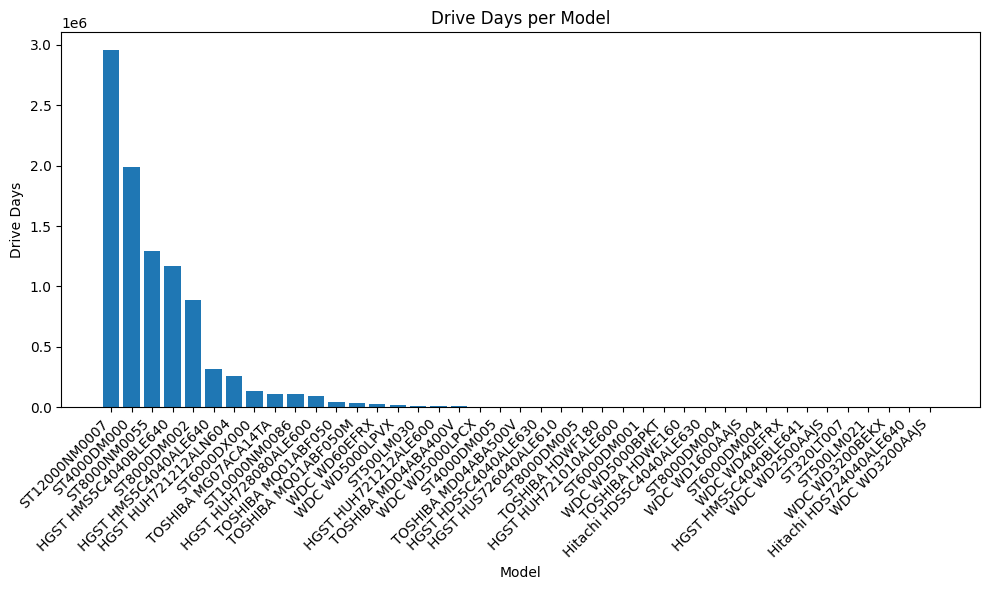

In [38]:
plt.figure(figsize=(10, 6))
plt.bar(drive_days['model'], drive_days['drive_days'])
plt.xlabel('Model')
plt.ylabel('Drive Days')
plt.title('Drive Days per Model')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('../img/drive_days_per_model.png')
plt.show()

In [28]:
# Total drive days across all models (which is also the total rows)
total_drive_days = len(df)
print(f'Total drive days across all models: {total_drive_days}')

Total drive days across all models: 9522894


### Step 2: Creating a dataframe that has the number of failures for each model.
### Written in SQL like this:

``` SQL
CREATE TABLE failures AS
    SELECT model, count(*) AS failures
    FROM drive_stats
    WHERE failure = 1
    GROUP BY model;
```

In [29]:
failures = df[df['failure'] == 1].groupby('model').size().reset_index(name='failures')
failures = failures.sort_values(by='failures', ascending=False).reset_index(drop=True)
failures.head()

,model,failures
0,ST12000NM0007,174
1,ST4000DM000,105
2,ST8000NM0055,57
3,ST8000DM002,27
4,TOSHIBA MQ01ABF050,13


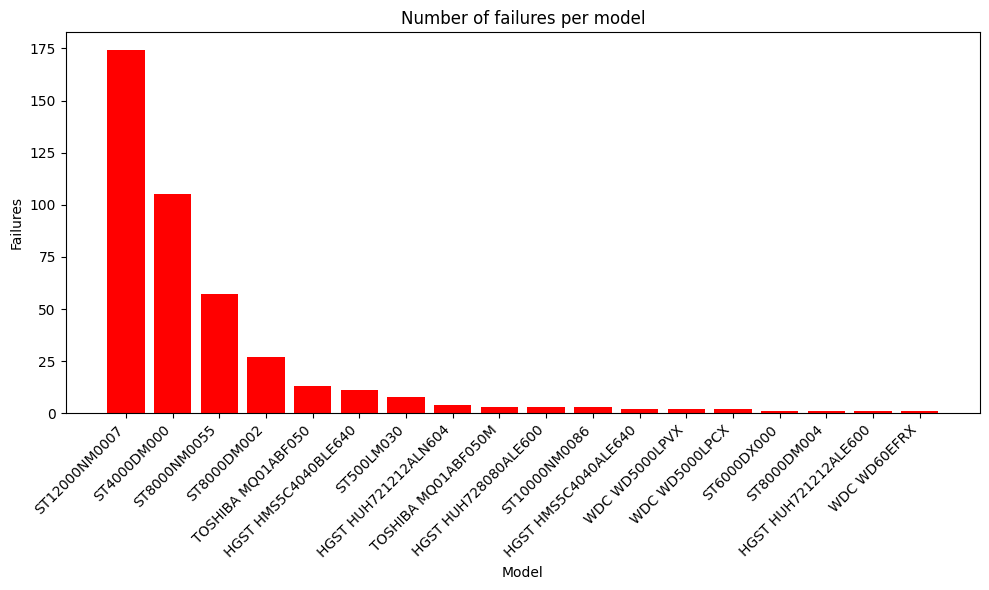

In [39]:
plt.figure(figsize=(10, 6))
plt.bar(failures['model'], failures['failures'], color='red')
plt.xlabel('Model')
plt.ylabel('Failures')
plt.title('Number of failures per model')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('../img/drive_failures_per_model.png')
plt.show()

### More data analysis

In [32]:
# Calculating the total failures
total_failures = (df['failure'] == 1).sum()
print(f'Total failures: {total_failures}')

# Calculating the total unique days
total_unique_days = df['date'].nunique()
print(f'Total unique days: {total_unique_days}')

print(f'Total drive days: {total_drive_days}')

print(f'So we have {total_failures} failures in {total_drive_days} drive days.')

Total failures: 418
Total unique days: 90
Total drive days: 9522894
So we have 418 failures in 9522894 drive days.


### The daily failure rate is the drive failures / drive days. The annual failure rate would be the daily failure rate * 365 (assuming the rest of the year would have similar results to the first 3 months)

In [33]:
daily_failure_rate = (total_failures / total_drive_days) * 100
annual_failure_rate = daily_failure_rate * 365

print(f'Daily failure rate is {daily_failure_rate}%')
print(f'Annual failure rate is {annual_failure_rate}%')

Daily failure rate is 0.004389421955132547%
Annual failure rate is 1.6021390136233797%


### Step 3: Creating a table that has the number of drives for each model on a given day. I will be using 31st March 2019 data.
### Written in SQL like this:

``` SQL
CREATE TABLE model_count AS
    SELECT model, count(*) AS count
    FROM drive_stats
    WHERE date = '2019-03-31'
    GROUP BY model;
```

In [34]:
# Convert 'date' column to datetime type
df['date'] = pd.to_datetime(df['date'])

# Filter rows for specific date and calculate the number of drives for each model
model_count = df[df['date'] == '2019-03-31'].groupby('model').size().reset_index(name='count')

# Sort the dataframe by 'count' in descending order
model_count = model_count.sort_values(by='count', ascending=False).reset_index(drop=True)
model_count.head()

,model,count
0,ST12000NM0007,34708
1,ST4000DM000,19785
2,ST8000NM0055,14381
3,HGST HMS5C4040BLE640,12753
4,ST8000DM002,9874


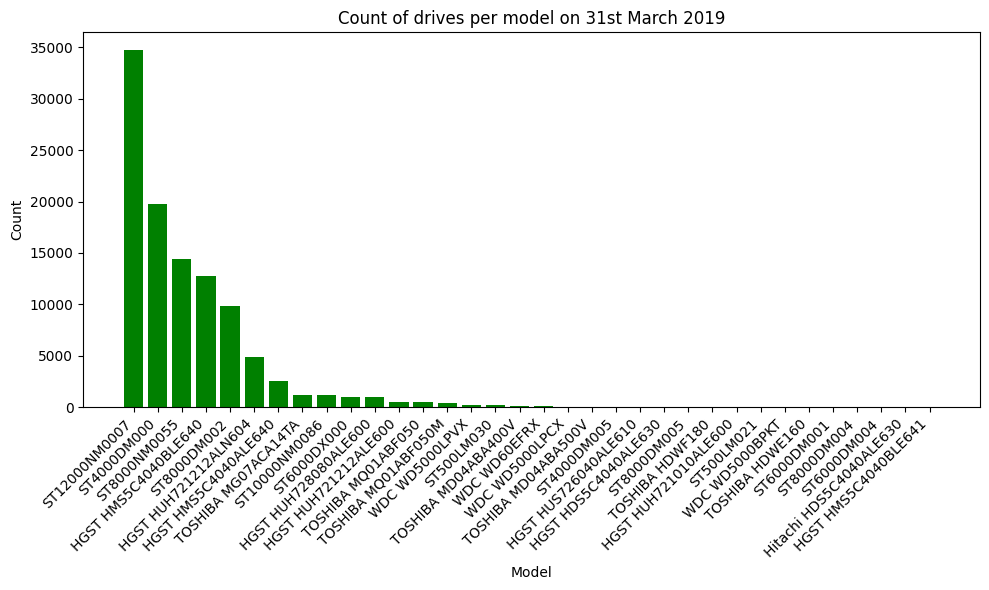

In [41]:
plt.figure(figsize=(10, 6))
plt.bar(model_count['model'], model_count['count'], color='green')
plt.xlabel('Model')
plt.ylabel('Count')
plt.title('Count of drives per model on 31st March 2019')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('../img/drive_count_per_model_on_31-03-2019.png')
plt.show()

### Join the tables together and compute the annual failure rate
### drive_years = drive_days / 365
### Annual failure rate = (number of failures / number of drive years) * 100
### Written in SQL like this:

``` SQL
CREATE TABLE failure_rates AS
    SELECT drive_days.model AS model,
           drive_days.drive_days AS drive_days,
           failures.failures AS failures, 
           100.0 * (1.0 * failures) / (drive_days / 365.0) AS annual_failure_rate
    FROM drive_days, failures, model_count
    WHERE drive_days.model = failures.model
      AND model_count.model = failures.model
    ORDER BY model;
```

In [42]:
# Merge dataframes
# The on='model' means that the merge should be performed based on the model column, 
# and only rows with matching model values in both DataFrames will be included in the result.
merged_df = pd.merge(drive_days, failures, on='model')
merged_df = pd.merge(merged_df, model_count, on='model')
merged_df.head()

,model,drive_days,failures,count
0,ST12000NM0007,2954794,174,34708
1,ST4000DM000,1989331,105,19785
2,ST8000NM0055,1294339,57,14381
3,HGST HMS5C4040BLE640,1172724,11,12753
4,ST8000DM002,888712,27,9874


In [43]:
# Calculate annual failure rate
failure_rates = merged_df.copy()
failure_rates['drive_years'] = failure_rates['drive_days'] / 365
failure_rates['annual_failure_rate (%)'] = (failure_rates['failures'] / failure_rates['drive_years']) * 100

failure_rates.head()

,model,drive_days,failures,count,drive_years,annual_failure_rate (%)
0,ST12000NM0007,2954794,174,34708,8095.326027,2.149388
1,ST4000DM000,1989331,105,19785,5450.221918,1.926527
2,ST8000NM0055,1294339,57,14381,3546.134247,1.607384
3,HGST HMS5C4040BLE640,1172724,11,12753,3212.942466,0.342365
4,ST8000DM002,888712,27,9874,2434.827397,1.108908


In [44]:
# Removing the count column
if 'count' in failure_rates.columns:
    failure_rates.drop('count', axis=1, inplace=True)
    print('Count column dropped')
else:
    print('Count column does not exist')

Count column dropped


### Moving the drive_years column next to the drive_days column

In [45]:
column_to_move = 'drive_years'
new_order = [col for col in failure_rates.columns if col != column_to_move]

In [46]:
new_order

['model', 'drive_days', 'failures', 'annual_failure_rate (%)']

In [47]:
new_order.insert(2, column_to_move)  # Insert 'drive_years' at index 2

In [48]:
new_order

['model', 'drive_days', 'drive_years', 'failures', 'annual_failure_rate (%)']

In [49]:
failure_rates = failure_rates[new_order]

### Sorted by failures

In [50]:
failure_rates.head()

,model,drive_days,drive_years,failures,annual_failure_rate (%)
0,ST12000NM0007,2954794,8095.326027,174,2.149388
1,ST4000DM000,1989331,5450.221918,105,1.926527
2,ST8000NM0055,1294339,3546.134247,57,1.607384
3,HGST HMS5C4040BLE640,1172724,3212.942466,11,0.342365
4,ST8000DM002,888712,2434.827397,27,1.108908


### Sorted by model

In [51]:
failure_rates.sort_values(by='model').reset_index(drop=True).head()

,model,drive_days,drive_years,failures,annual_failure_rate (%)
0,HGST HMS5C4040ALE640,313365,858.534247,2,0.232955
1,HGST HMS5C4040BLE640,1172724,3212.942466,11,0.342365
2,HGST HUH721212ALE600,14040,38.465753,1,2.599715
3,HGST HUH721212ALN604,259370,710.602740,4,0.562902
4,HGST HUH728080ALE600,93598,256.432877,3,1.169897


### Sorted by annual failure rate. Notice the outlier in the annual failure rate.

In [52]:
sorted_AFR = failure_rates.sort_values(by='annual_failure_rate (%)', ascending=False).reset_index(drop=True)
sorted_AFR.head()

,model,drive_days,drive_years,failures,annual_failure_rate (%)
0,ST8000DM004,273,0.747945,1,133.699634
1,ST500LM030,14479,39.668493,8,20.167139
2,WDC WD5000LPCX,4920,13.479452,2,14.837398
3,TOSHIBA MQ01ABF050,46969,128.682192,13,10.102408
4,TOSHIBA MQ01ABF050M,32624,89.380822,3,3.356425


### Analysing the Annual Failure Rate per model

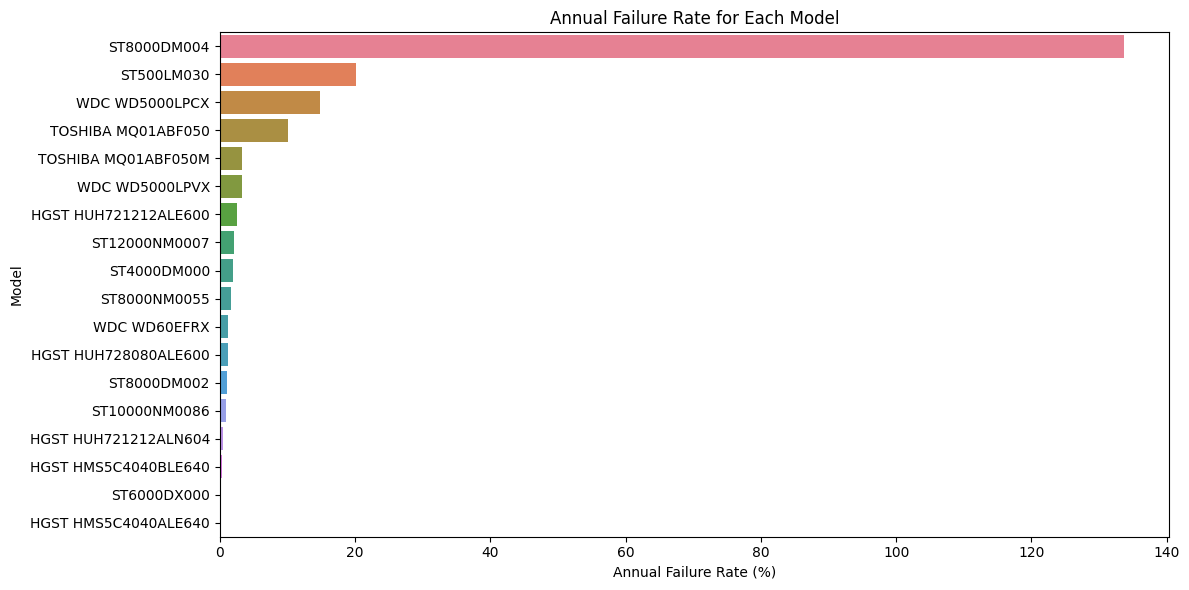

In [127]:
plt.figure(figsize=(12, 6))
sns.barplot(data=sorted_AFR, x='annual_failure_rate (%)', y='model', hue='model')
plt.title('Annual Failure Rate for Each Model')
plt.xlabel('Annual Failure Rate (%)')
plt.ylabel('Model')
plt.tight_layout()
plt.savefig('../img/AFR_for_each_model.png')
plt.show()

### Analysing the outlier

In [56]:
df[df['model'] == 'ST8000DM004'].shape

(273, 33)

In [65]:
df[df['model'] == 'ST8000DM004'].reset_index(drop=True)

,date,serial_number,model,capacity_bytes,failure,smart_1_normalized,smart_1_raw,smart_3_normalized,smart_3_raw,smart_4_normalized,...,smart_193_normalized,smart_193_raw,smart_194_normalized,smart_194_raw,smart_197_normalized,smart_197_raw,smart_198_normalized,smart_198_raw,smart_199_normalized,smart_199_raw
0,2019-01-01,WCT0EJDY,ST8000DM004,8001563222016,0,54.0,191168752.0,99.0,0.0,100.0,...,100.0,1306.0,34.0,34.0,100.0,0.0,100.0,0.0,200.0,0.0
1,2019-01-01,WCT0EJDJ,ST8000DM004,8001563222016,0,84.0,235326880.0,99.0,0.0,100.0,...,100.0,190.0,28.0,28.0,100.0,0.0,100.0,0.0,200.0,0.0
2,2019-01-01,WCT0EKW3,ST8000DM004,8001563222016,0,84.0,225101728.0,99.0,0.0,100.0,...,100.0,196.0,32.0,32.0,100.0,0.0,100.0,0.0,200.0,0.0
3,2019-01-01,WCT0EJY6,ST8000DM004,8001563222016,0,71.0,13389032.0,99.0,0.0,100.0,...,100.0,124.0,28.0,28.0,100.0,8.0,100.0,8.0,200.0,0.0
4,2019-01-02,WCT0EJDY,ST8000DM004,8001563222016,0,54.0,191288728.0,99.0,0.0,100.0,...,100.0,1307.0,34.0,34.0,100.0,0.0,100.0,0.0,200.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
268,2019-03-30,WCT0EKW3,ST8000DM004,8001563222016,0,73.0,209319416.0,99.0,0.0,100.0,...,100.0,343.0,30.0,30.0,100.0,8.0,100.0,8.0,200.0,0.0
269,2019-03-30,WCT0EJY6,ST8000DM004,8001563222016,0,77.0,202578152.0,99.0,0.0,100.0,...,100.0,243.0,29.0,29.0,100.0,8.0,100.0,8.0,200.0,0.0
270,2019-03-31,WCT0EJDJ,ST8000DM004,8001563222016,0,77.0,56104136.0,98.0,0.0,100.0,...,100.0,278.0,27.0,27.0,100.0,0.0,100.0,0.0,200.0,0.0
271,2019-03-31,WCT0EKW3,ST8000DM004,8001563222016,0,78.0,228606704.0,99.0,0.0,100.0,...,100.0,344.0,30.0,30.0,100.0,8.0,100.0,8.0,200.0,0.0


In [63]:
df[(df['model'] == 'ST8000DM004') & (df['failure'] == 1)]

,date,serial_number,model,capacity_bytes,failure,smart_1_normalized,smart_1_raw,smart_3_normalized,smart_3_raw,smart_4_normalized,...,smart_193_normalized,smart_193_raw,smart_194_normalized,smart_194_raw,smart_197_normalized,smart_197_raw,smart_198_normalized,smart_198_raw,smart_199_normalized,smart_199_raw
226302,2019-01-03,WCT0EJDY,ST8000DM004,8001563222016,1,55.0,86687530.0,99.0,0.0,100.0,...,100.0,1426.0,37.0,37.0,100.0,0.0,100.0,0.0,200.0,0.0


In [68]:
sorted_df = df.groupby('model')['serial_number'].nunique().reset_index()
sorted_df = sorted_df.rename(columns={'serial_number': 'unique_drives'})
sorted_df = sorted_df.sort_values(by='unique_drives', ascending=True)

In [86]:
sorted_df.head(10)

,model,unique_drives
13,ST320LT007,1
3,HGST HMS5C4040BLE641,1
35,WDC WD3200BEKX,1
34,WDC WD3200AAJS,1
10,Hitachi HDS724040ALE640,1
33,WDC WD2500AAJS,1
36,WDC WD40EFRX,2
19,ST6000DM004,2
22,ST8000DM004,4
25,TOSHIBA HDWE160,10


From the above analysis, it shows that there are a total of 4 unique drives of model ST8000DM004, one of which failed. Due to the low number of unique drives of this model, the drive days ended up being very low which significantly affected the annual failure rate. As the Annual failure rate = (number of failures / number of drive years) * 100. Therefore (1/[273/365]) * 100 = 133.7

### Removing the outlier model that has an annual failure rate of 133.7%

In [87]:
AFR_without_outlier = sorted_AFR.copy()  

if 'ST8000DM004' in AFR_without_outlier['model'].values:
    AFR_without_outlier.drop(AFR_without_outlier[AFR_without_outlier['model'] == 'ST8000DM004'].index, inplace=True)
    print('Row with model ST8000DM004 dropped')
else:
    print('Row with model ST8000DM004 does not exist')

Row with model ST8000DM004 dropped


In [88]:
AFR_without_outlier.reset_index(drop=True).head()

,model,drive_days,drive_years,failures,annual_failure_rate (%)
0,ST500LM030,14479,39.668493,8,20.167139
1,WDC WD5000LPCX,4920,13.479452,2,14.837398
2,TOSHIBA MQ01ABF050,46969,128.682192,13,10.102408
3,TOSHIBA MQ01ABF050M,32624,89.380822,3,3.356425
4,WDC WD5000LPVX,22015,60.315068,2,3.315921


### Analysing the annual failure rate per model without outlier (model ST8000DM004)

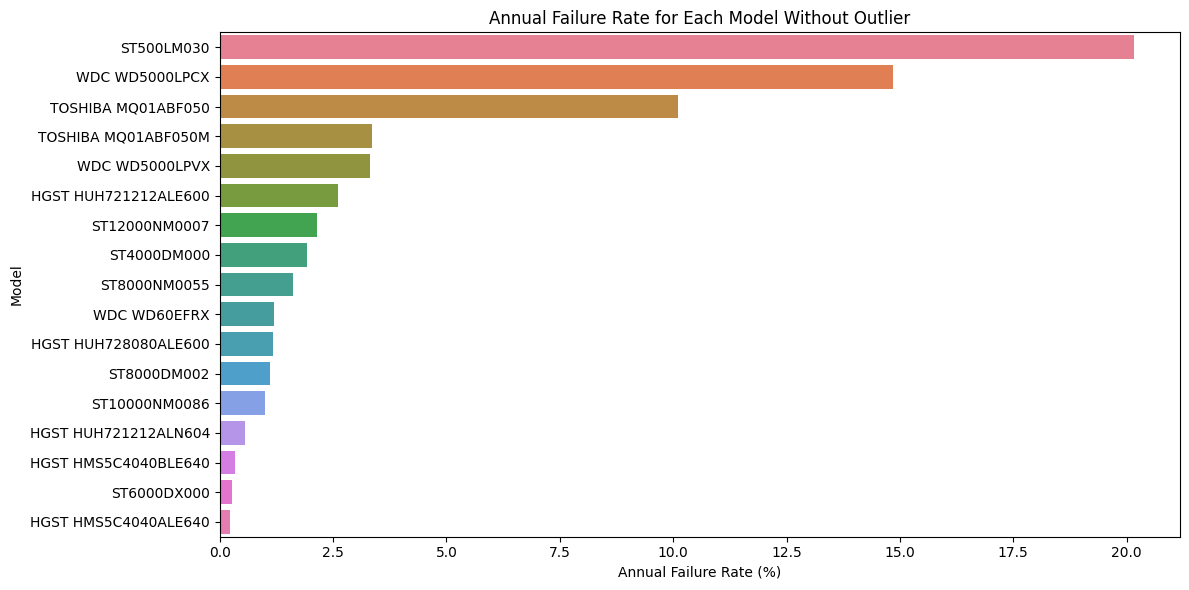

In [149]:
plt.figure(figsize=(12, 6))
sns.barplot(data=AFR_without_outlier, x='annual_failure_rate (%)', y='model', hue='model')
plt.title('Annual Failure Rate for Each Model Without Outlier')
plt.xlabel('Annual Failure Rate (%)')
plt.ylabel('Model')
plt.tight_layout()
plt.savefig('../img/AFR_for_each_model_without_outlier.png')
plt.show()

### Drive years per model

In [94]:
sorted_df.sort_values(by='unique_drives', ascending=False).head()

,model,unique_drives
12,ST12000NM0007,34905
14,ST4000DM000,23236
2,HGST HMS5C4040BLE640,14558
24,ST8000NM0055,14441
21,ST8000DM002,9908


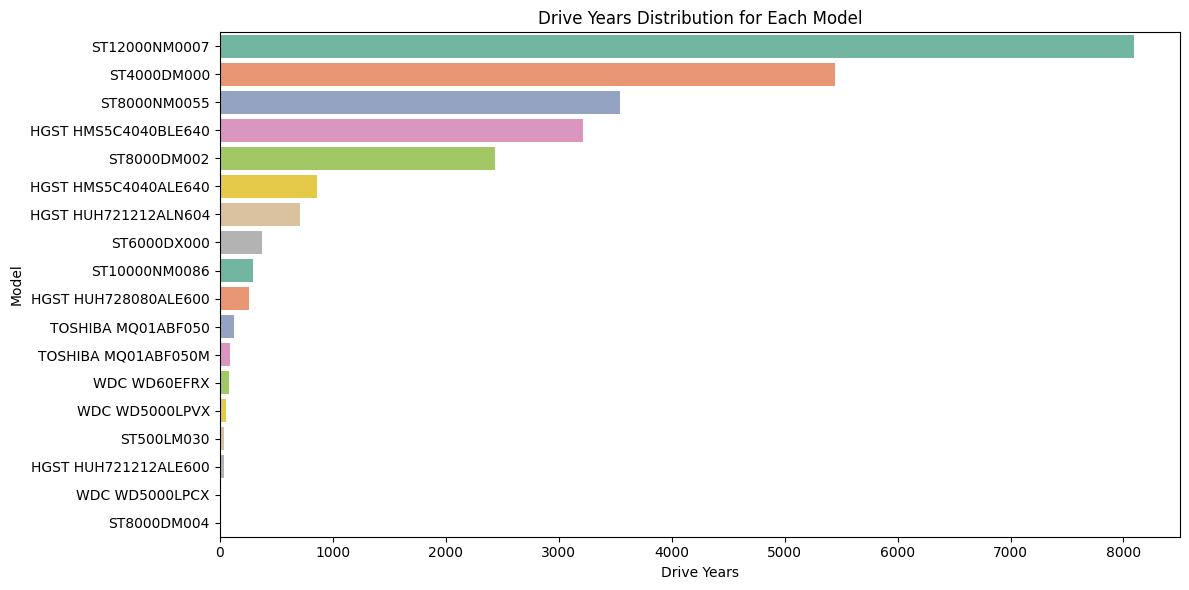

In [122]:
plt.figure(figsize=(12, 6))
sns.barplot(data=failure_rates, x='drive_years', y='model', hue='model', palette='Set2')
plt.title('Drive Years Distribution for Each Model')
plt.xlabel('Drive Years')
plt.ylabel('Model')
plt.tight_layout()
plt.savefig('../img/drive_years_per_model.png')
plt.show()

### Failures per model

In [97]:
sorted_failures = failure_rates.sort_values(by='failures', ascending=False).reset_index(drop=True)
sorted_failures.head()

,model,drive_days,drive_years,failures,annual_failure_rate (%)
0,ST12000NM0007,2954794,8095.326027,174,2.149388
1,ST4000DM000,1989331,5450.221918,105,1.926527
2,ST8000NM0055,1294339,3546.134247,57,1.607384
3,ST8000DM002,888712,2434.827397,27,1.108908
4,TOSHIBA MQ01ABF050,46969,128.682192,13,10.102408


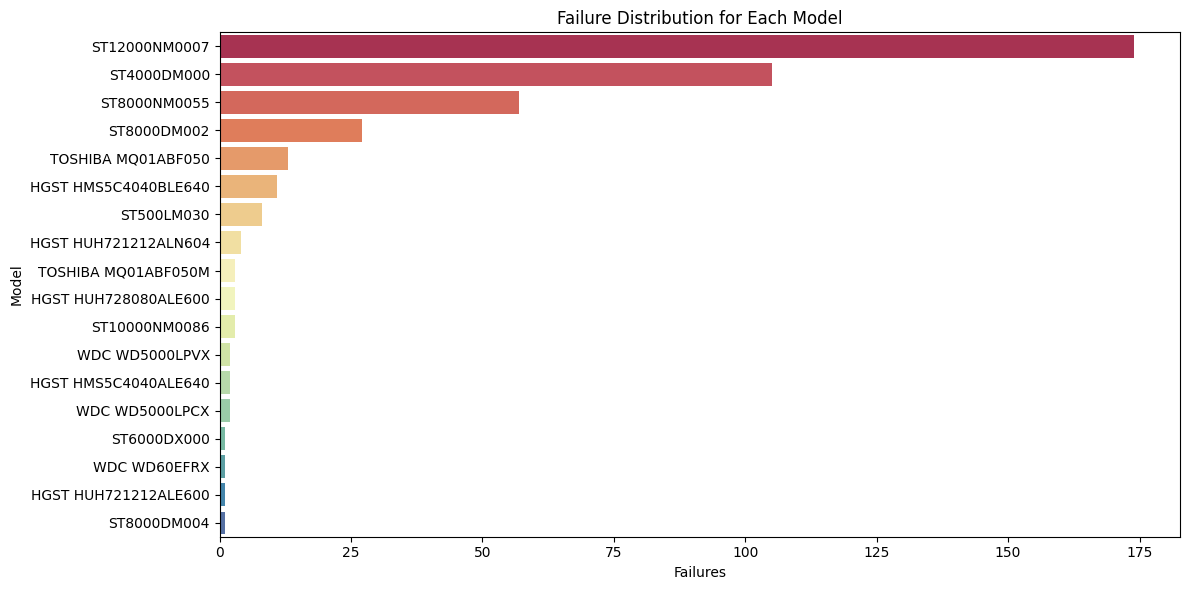

In [120]:
plt.figure(figsize=(12, 6))
sns.barplot(data=sorted_failures, x='failures', y='model', hue='model', palette='Spectral')
plt.title('Failure Distribution for Each Model')
plt.xlabel('Failures')
plt.ylabel('Model')
plt.tight_layout()
plt.savefig('../img/failures_per_model.png')
plt.show()

### Scatter plot of each model's drive year to failures
The greater the drive years, the higher the failures. This could be due to there existing many more unique drives of the models with high drive years. More hard drives generally mean more failures.

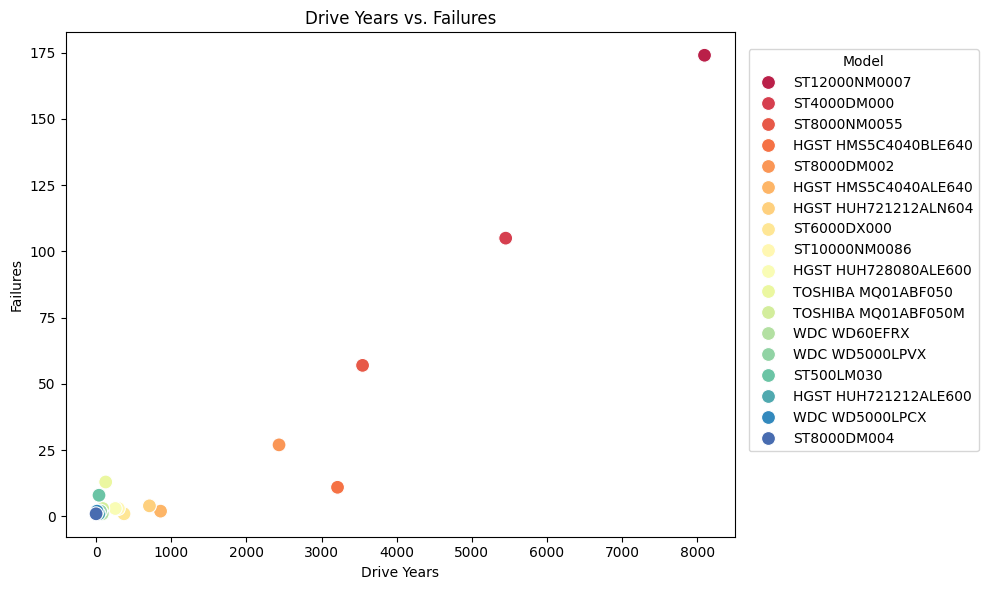

In [148]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=failure_rates, x=failure_rates['drive_years'], y=failure_rates['failures'], hue='model', s=100, palette='Spectral')
plt.title('Drive Years vs. Failures')
plt.xlabel('Drive Years')
plt.ylabel('Failures')
plt.legend(title='Model', bbox_to_anchor=(1.01, 0.98), loc='upper left')
plt.tight_layout()
plt.savefig('../img/scatter_plot_drive_years_to_failures.png')
plt.show()